In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from exp.nb_07a import *

In [3]:
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette-160'

## Image ItemList

### Get images

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/home/jupyter/.fastai/data/imagenette-160')

In [5]:
import PIL, os, mimetypes

In [6]:
Path.ls = lambda x: list(x.iterdir())

In [7]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imagenette-160/train'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val')]

In [8]:
(path/'val').ls()

[PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n03028079'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n03000684'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n02102040'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n03417042'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n03394916'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n03888257'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n03445777'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n03425413'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n02979186'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n01440764')]

In [9]:
path_tench = path/'val'/'n01440764'

In [10]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00024327.JPEG')

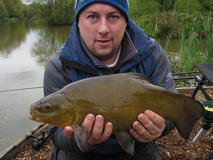

In [11]:
img = PIL.Image.open(img_fn)
img

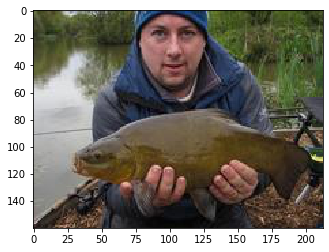

In [12]:
plt.imshow(img)

In [13]:
import numpy 
imga = numpy.array(img)

In [14]:
imga.shape

(160, 213, 3)

In [15]:
imga[:10,:10,0]

array([[ 88,  89,  83,  73, ...,  79,  76,  82,  84],
       [106, 103,  92,  75, ...,  70,  69,  75,  80],
       [105, 103,  94,  79, ...,  73,  77,  76,  78],
       [ 91,  94,  94,  86, ...,  77,  82,  80,  79],
       ...,
       [ 65,  70,  82,  92, ...,  67,  65,  63,  66],
       [ 70,  71,  77,  86, ...,  64,  63,  63,  66],
       [ 61,  62,  70,  82, ...,  64,  59,  59,  64],
       [ 65,  64,  67,  75, ...,  73,  64,  59,  61]], dtype=uint8)

In [16]:
image_extensions = set(k for k, v in mimetypes.types_map.items() if v.startswith('image'))

In [17]:
' '.join(image_extensions)

'.svg .jpeg .pnm .pgm .jpg .tif .bmp .ico .png .tiff .gif .rgb .jpe .xbm .ras .ppm .xwd .xpm .pbm .ief'

In [18]:
def setify(o): return o if isinstance(o, set) else set(listify(o))

In [19]:
test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa',1]), {'aa',1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

In [20]:
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs
           if not f.startswith('.')
           and ((not extensions)
                or f".{f.split('.')[-1].lower()}" in extensions)]
    return res

In [21]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/home/jupyter/.fastai/data/imagenette-160/ILSVRC2012_val_00024327.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/ILSVRC2012_val_00037596.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/ILSVRC2012_val_00009396.JPEG')]

In [22]:
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {o.lower() for o in extensions}
    if recurse:
        res = []
        for i, (p, d, f) in enumerate(os.walk(path)):
            if include is not None and i == 0: 
                d[:] = [o for o in d if o in include]
            else: 
                d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

In [23]:
get_files(path_tench, image_extensions)[:3]

[PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00024327.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00037596.JPEG'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00009396.JPEG')]

In [24]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

In [25]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

65.5 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Prepare for modelling

### Get files

In [26]:
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

In [27]:
class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path, self.tfms = Path(path), tfms
        
    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls = self.__class__
        return cls(items, self.path, tfms=self.tfms)
            
    def get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res, list): return [self._get(o) for o in res]
        return self._get(res)

In [28]:
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

In [29]:
class Transform(): _order = 0
    
class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')
    
def make_rgb(item): return item.convert('RGB')

In [30]:
il = ImageList.from_files(path, tfms=make_rgb)

In [31]:
il

ImageList (13394 items)
[PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_14885.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_2088.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_115023.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_5153.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_93165.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_7287.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_32105.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_2941.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_10988.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_12732.JPEG')...]
Path: /home/jupyter/.fastai/data/imagenette-1

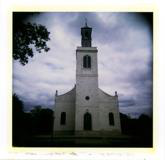

In [32]:
img = il[0]; img

### Split validation set

In [33]:
fn = il.items[0]; fn

PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_14885.JPEG')

In [34]:
fn.parent.parent.name

'train'

In [35]:
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

def split_by_func(items, f):
    mask = [f(o) for o in items]
    f = [o for o, m in zip(items, mask) if m==False]
    t = [o for o, m in zip(items, mask) if m==True]
    return f, t

In [36]:
splitter = partial(grandparent_splitter, valid_name='val')

In [37]:
%time train, valid = split_by_func(il, splitter)

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 32.2 ms


In [38]:
len(train), len(valid)

(12894, 500)

In [39]:
class SplitData():
    def __init__(self, train, valid): 
        self.train, self.valid = train, valid
    def __getattr__(self, k): return getattr(self.train, k)
    def __setstate__(self, data:Any): self.__dict__.update(data)
    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
        return cls(*lists)
    def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [40]:
sd = SplitData.split_by_func(il, splitter)

In [41]:
type(il), type(sd), type(sd.train), type(sd.valid)

(__main__.ImageList,
 __main__.SplitData,
 __main__.ImageList,
 __main__.ImageList)

### Labeling

In [42]:
from collections import OrderedDict

In [43]:
def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res

In [44]:
class Processor():
    def process(self, items): return items
    
class CategoryProcessor(Processor):
    def __init__(self): self.vocab = None
        
    def __call__(self, items):
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi = {v:k for k, v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    
    def proc1(self, item): return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    
    def deproc1(self, idx): return self.vocab[idx]

In [45]:
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList):
    return cls([f(o) for o in ds.items], path=ds.path)

class LabeledData():
    
    def process(self, il, proc): return il.new(compose(il.items, proc))
    
    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x, self.y = self.process(x, proc_x), self.process(y, proc_y)
        self.proc_x, self.proc_y = proc_x, proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    
    def __getitem__(self, idx): return self.x[idx], self.y[idx]
    
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx, torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item
    
    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)

def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train, valid) 

In [46]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [47]:
assert ll.train.proc_y is ll.valid.proc_y

In [48]:
ll.train.y

ItemList (12894 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
Path: /home/jupyter/.fastai/data/imagenette-160

In [49]:
ll.train.y.items[0], ll.train.y_obj(0), ll.train.y_obj(slice(2))

(0, 'n03028079', ['n03028079', 'n03028079'])

In [50]:
ll

SplitData
Train: LabeledData
x: ImageList (12894 items)
[PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_14885.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_2088.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_115023.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_5153.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_93165.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_7287.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_32105.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_2941.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_10988.JPEG'), PosixPath('/home/jupyter/.fastai/data/imagenette-160/train/n03028079/n03028079_12732.JPEG')...]
Path: /home/j

### Transform to tensor

In [51]:
ll.train[6]

(<PIL.Image.Image image mode=RGB size=160x215 at 0x7FDE1A6D5D90>, 0)

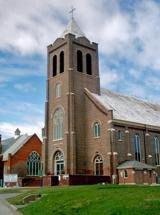

In [52]:
ll.train[6][0]

In [53]:
ll.train[6][0].size

(160, 215)

In [54]:
ll.train[6][0].tobytes()[:10], len(ll.train[6][0].tobytes()), 160 * 215 * 3

(b'\xc6\xc6\xd2\xc5\xc5\xd1\xc3\xc3\xcf\xc1', 103200, 103200)

In [55]:
print(torch.ByteStorage.from_buffer(ll.train[6][0].tobytes())[:10])
torch.ByteStorage.from_buffer(ll.train[6][0].tobytes()).size()

 198
 198
 210
 197
 197
 209
 195
 195
 207
 193
[torch.ByteStorage of size 10]


103200

In [56]:
print(type(torch.ByteStorage.from_buffer(ll.train[6][0].tobytes())))
torch.ByteStorage.from_buffer(ll.train[6][0].tobytes()).dtype

<class 'torch.ByteStorage'>


torch.uint8

In [57]:
print(type(torch.ByteTensor(torch.ByteStorage.from_buffer(ll.train[6][0].tobytes()))))
torch.ByteTensor(torch.ByteStorage.from_buffer(ll.train[6][0].tobytes())).dtype

<class 'torch.Tensor'>


torch.uint8

In [58]:
class ResizeFixed(Transform):
    _order = 10
    def __init__(self, size):
        if isinstance(size, int): size = (size, size)
        self.size = size
    def __call__(self, x): return x.resize(self.size, PIL.Image.BILINEAR)

def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w, h = item.size
    return res.view(h, w, -1).permute(2, 0, 1)
to_byte_tensor._order = 20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order = 30

In [59]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [60]:
ll.train[0][0].size(), ll.train[0][0].dtype

(torch.Size([3, 128, 128]), torch.float32)

In [61]:
def show_image(im, figsize=(3, 3)):
    plt.figure(figsize=(figsize))
    plt.axis('off')
    plt.imshow(im.permute(1, 2, 0))

In [62]:
x, y = ll.train[9]
x.shape

torch.Size([3, 128, 128])

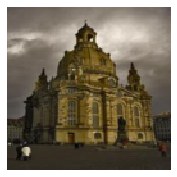

In [63]:
show_image(x)

## Modeling

### DataBunch

In [64]:
bs = 64

In [65]:
train_dl, valid_dl = get_dls(ll.train, ll.valid, bs, num_workers=4)

In [66]:
x, y = next(iter(train_dl))

In [67]:
x.shape

torch.Size([64, 3, 128, 128])

'n03028079'

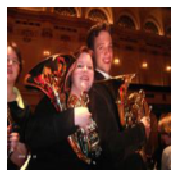

In [68]:
show_image(x[51])
ll.train.y_obj(51)

In [69]:
y

tensor([3, 8, 0, 0, 9, 9, 4, 4, 0, 3, 4, 3, 0, 0, 6, 0, 0, 5, 8, 0, 3, 4, 0, 8,
        4, 0, 9, 1, 0, 6, 0, 7, 1, 8, 0, 7, 3, 1, 4, 7, 7, 2, 2, 6, 0, 0, 8, 3,
        7, 4, 8, 4, 6, 8, 0, 1, 3, 5, 8, 2, 0, 7, 4, 5])

In [70]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl, self.valid_dl, self.c_in, self.c_out = train_dl, valid_dl, c_in, c_out
        
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [71]:
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

In [72]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

### Model

In [73]:
cbfs = [partial(AvgStatsCallback, accuracy), 
        CudaCallback]

In [78]:
m, s = x.mean((0, 2, 3)).cuda(), x.std((0, 2, 3)).cuda()
m, s

(tensor([0.4885, 0.4826, 0.4468], device='cuda:0'),
 tensor([0.2870, 0.2865, 0.3035], device='cuda:0'))

In [80]:
def normalize_chan(x, mean, std):
    return (x - mean[..., None, None]) / std[..., None, None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])
norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [81]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

In [82]:
nfs = [64, 64, 128, 256]

In [89]:
import math
def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1*3*3)
    layers = [f(l1, l2, stride=1),
              f(l2, 2*l2, stride=2),
              f(2*l2, 4*l2, stride=2)]
    nfs = [4*l2] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten),
               nn.Linear(nfs[-1], data.c_out)]
    return layers
    
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [90]:
sched = combine_scheds([0.3, 0.7], cos_1cycle_anneal(.1, .3, .05))

In [91]:
learn, run = get_learn_run(nfs, data, .2, conv_layer, cbs=cbfs+[
    partial(ParamScheduler, 'lr', sched)
])

In [92]:
def model_summary(run, learn, data, find_all=False):
    xb, yb = get_batch(data.valid_dl, run)
    device = next(learn.model.parameters()).device
    xb, yb = xb.to(device), yb.to(device)
    mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
    f = lambda hook, mod, inp, out: print(f"{mod}\n{out.shape}\n")
    with Hooks(mods, f) as hooks: learn.model(xb)

In [93]:
model_summary(run, learn, data)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 16, 128, 128])

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 32, 64, 64])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 32, 32])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([128, 64, 16, 16])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(

In [94]:
%time run.fit(5, learn)

train: [1.7104335410365286, tensor(0.4116, device='cuda:0')]
valid: [1.824154052734375, tensor(0.4060, device='cuda:0')]
train: [1.278515867360788, tensor(0.5738, device='cuda:0')]
valid: [1.1791163330078125, tensor(0.6140, device='cuda:0')]
train: [0.924480226995114, tensor(0.7024, device='cuda:0')]
valid: [0.9413704833984375, tensor(0.7000, device='cuda:0')]
train: [0.6036742577094967, tensor(0.8098, device='cuda:0')]
valid: [0.896842529296875, tensor(0.7080, device='cuda:0')]
train: [0.34934592124970915, tensor(0.9034, device='cuda:0')]
valid: [0.8672120361328125, tensor(0.7360, device='cuda:0')]
CPU times: user 26.5 s, sys: 10.3 s, total: 36.8 s
Wall time: 1min 10s
